In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# import reduce_memory_usage
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
from prettytable import PrettyTable
import pickle
pd.set_option('display.float_format',lambda x:f'{x:.3f}')
#pd.set_option('display.max_columns', None)

In [3]:
# 1. Loading the dataset
dftrain=pd.read_csv('D:\\Downloads\\bigmart\\sales_train.csv')
dftest = pd.read_csv('D:\\Downloads\\bigmart\\test.csv')
dfitems = pd.read_csv('D:\\Downloads\\bigmart\\items.csv')

In [4]:
print(dftrain.shape)
print(dftrain.head())
print(dftrain.info()) #to see datatype of each column

(2935849, 6)
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154     999.000         1.000
1  03.01.2013               0       25     2552     899.000         1.000
2  05.01.2013               0       25     2552     899.000        -1.000
3  06.01.2013               0       25     2554    1709.050         1.000
4  15.01.2013               0       25     2555    1099.000         1.000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None


In [5]:
print(dftrain.describe())

       date_block_num     shop_id     item_id  item_price  item_cnt_day
count     2935849.000 2935849.000 2935849.000 2935849.000   2935849.000
mean           14.570      33.002   10197.227     890.853         1.243
std             9.423      16.227    6324.297    1729.800         2.619
min             0.000       0.000       0.000      -1.000       -22.000
25%             7.000      22.000    4476.000     249.000         1.000
50%            14.000      31.000    9343.000     399.000         1.000
75%            23.000      47.000   15684.000     999.000         1.000
max            33.000      59.000   22169.000  307980.000      2169.000


In [6]:
print(dftrain.isnull().sum()/len(dftrain) *100)

date             0.000
date_block_num   0.000
shop_id          0.000
item_id          0.000
item_price       0.000
item_cnt_day     0.000
dtype: float64


In [7]:
print('number of duplicates:',len(dftrain[dftrain.duplicated()]))

number of duplicates: 6


In [8]:
# 2.date column into date datatype and ordering as date
dftrain['date'] = pd.to_datetime(dftrain['date'],format='%d.%m.%Y')
dftrain.sort_values(by='date',inplace=True)
print(dftrain.head())
print(dftrain.date.min(),'to',dftrain.date.max())

            date  date_block_num  shop_id  item_id  item_price  item_cnt_day
49800 2013-01-01               0       18     5823    2500.000         1.000
29784 2013-01-01               0       27     5573     849.000         1.000
35476 2013-01-01               0        7     1006     399.000         1.000
8330  2013-01-01               0       19    17707     899.000         1.000
57384 2013-01-01               0       14    19548     149.000         1.000
2013-01-01 00:00:00 to 2015-10-31 00:00:00


In [9]:
dftrain2 = dftrain.merge(dfitems,on='item_id',how ='left')
dftest2 = dftest.merge(dfitems,on='item_id',how='left')
print(len(dftrain.shop_id.unique()))
print(len(dftrain.item_id.unique()))
print(len(dftrain2.item_category_id.unique()))
print(dftrain2.head())

60
21807
84
        date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-01               0       18     5823    2500.000         1.000   
1 2013-01-01               0       27     5573     849.000         1.000   
2 2013-01-01               0        7     1006     399.000         1.000   
3 2013-01-01               0       19    17707     899.000         1.000   
4 2013-01-01               0       14    19548     149.000         1.000   

                                           item_name  item_category_id  
0  Playstation Store пополнение бумажника: Карта ...                35  
1  PS Move Motion Controller Charger (Зарядная ст...                 2  
2                       3D Crystal Puzzle Дельфин XL                67  
3  Праздник спорта (Essentials) (только для PS Mo...                19  
4                     ТАКИЕ РАЗНЫЕ БЛИЗНЕЦЫ (регион)                40  


In [10]:
# 3.outliers in item_cnt_day
print(dftrain.item_cnt_day.describe())
outlier_item_cnt = np.percentile(dftrain.item_cnt_day.values,100)
print(outlier_item_cnt )
for i in range(90,101):
    print('{}th percentile value of item count:{}'.format(i,np.percentile(dftrain.item_cnt_day,i)))

count   2935849.000
mean          1.243
std           2.619
min         -22.000
25%           1.000
50%           1.000
75%           1.000
max        2169.000
Name: item_cnt_day, dtype: float64
2169.0
90th percentile value of item count:2.0
91th percentile value of item count:2.0
92th percentile value of item count:2.0
93th percentile value of item count:2.0
94th percentile value of item count:2.0
95th percentile value of item count:2.0
96th percentile value of item count:2.0
97th percentile value of item count:3.0
98th percentile value of item count:3.0
99th percentile value of item count:5.0
100th percentile value of item count:2169.0


In [ ]:
# so it is clear that 99% of data has 5 or less item_cnt_day
# only 1 % has more than 5 item_cnt_day

In [11]:
# outliers in item price column:
for i in range(90,101):
    print('{}th percentile value of item price:{}'.format(i,np.percentile(dftrain.item_price,i)))

90th percentile value of item price:1999.0
91th percentile value of item price:2090.0
92th percentile value of item price:2299.0
93th percentile value of item price:2499.0
94th percentile value of item price:2599.0
95th percentile value of item price:2690.0
96th percentile value of item price:2999.0
97th percentile value of item price:3190.0
98th percentile value of item price:3590.0
99th percentile value of item price:5999.0
100th percentile value of item price:307980.0


60


C:\Users\arsam\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\arsam\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\arsam\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


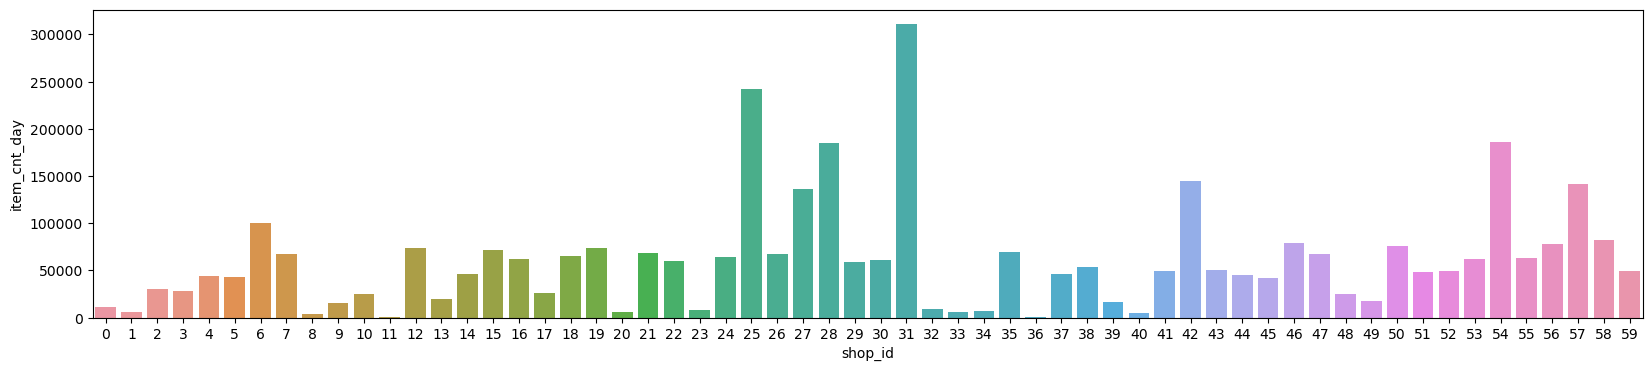

In [12]:
# to see shopwise selling count
dftrain3= dftrain.groupby(['shop_id'],as_index=False)['item_cnt_day'].sum()
print(len(dftrain3))
plt.figure(figsize=(20,4))
sns.barplot(dftrain3,x='shop_id',y='item_cnt_day')
plt.show()

34


C:\Users\arsam\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\arsam\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\arsam\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


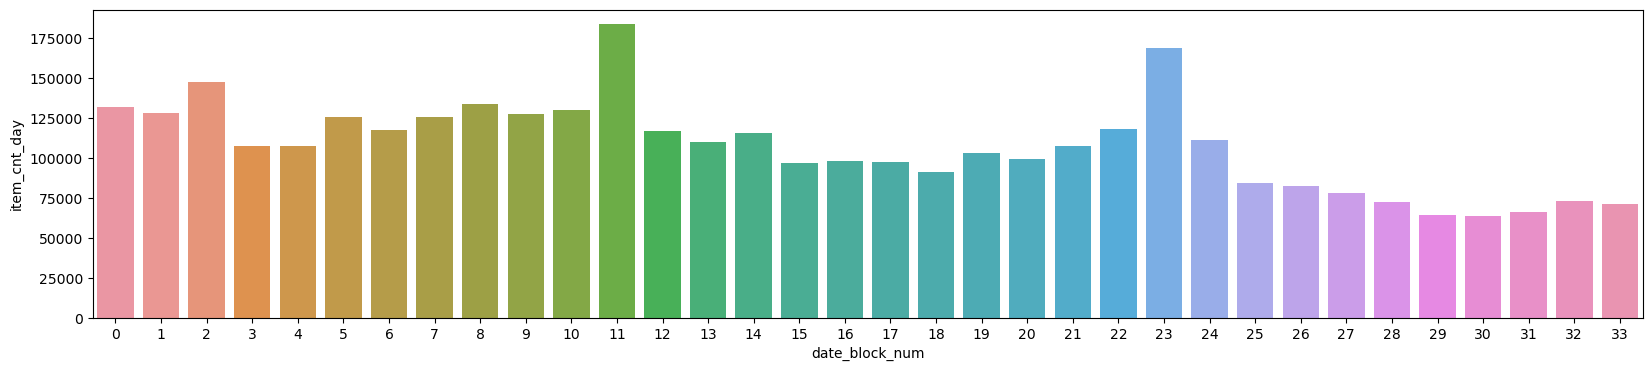

In [13]:
# to see monthwise selling
dftrain3= dftrain.groupby(['date_block_num'],as_index=False)['item_cnt_day'].sum()
print(len(dftrain3))
plt.figure(figsize=(20,4))
sns.barplot(dftrain3,x='date_block_num',y='item_cnt_day')
plt.show()

In [14]:
# 4.remove shops,items not in test dataset b/c training only wanted details gives high accuracy
test_shop = dftest['shop_id'].unique()
test_item = dftest['item_id'].unique()
print(len(test_shop),'**',len(test_item))
_train = dftrain[dftrain['shop_id'].isin(test_shop)]
_train = _train[_train['item_id'].isin(test_item)]
print(_train.shape)
print(_train.describe())

42 ** 5100
(1224439, 6)
                                date  date_block_num     shop_id     item_id  \
count                        1224439     1224439.000 1224439.000 1224439.000   
mean   2014-08-27 00:42:40.869753344          19.355      32.151    9614.866   
min              2013-01-01 00:00:00           0.000       2.000      30.000   
25%              2014-01-18 00:00:00          12.000      19.000    4181.000   
50%              2014-10-12 00:00:00          21.000      31.000    7856.000   
75%              2015-04-10 00:00:00          27.000      46.000   15229.000   
max              2015-10-31 00:00:00          33.000      59.000   22167.000   
std                              NaN           9.111      16.466    6299.870   

       item_price  item_cnt_day  
count 1224439.000   1224439.000  
mean     1030.666         1.321  
min         0.500       -16.000  
25%       299.000         1.000  
50%       549.000         1.000  
75%      1199.000         1.000  
max     59200.000

In [15]:
# 5.outlier removal:
train =_train[(_train.item_price<5000) & (_train.item_cnt_day<1000)]
# removing negative values
train= train[(train.item_price>0) & (train.item_cnt_day>=0)].reset_index(drop=True)
print(train.shape)

(1210127, 6)


In [16]:
# Cleaning shops data
# We have different shop ids for same shop names like 0-57, 1-58, 11,10, 40-39
# We dont have 0,1,11 and 40 shop_id in test data so we are replacing these with shop_id which shares a similar names
train.loc[train.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 11, 'shop_id'] = 10
train.loc[train.shop_id == 40, 'shop_id'] = 39

train = train.merge(dfitems,on='item_id',how ='left')
print(train.head())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-01               0       18     5823    2500.000         1.000   
1 2013-01-01               0       42    15702     549.000         1.000   
2 2013-01-01               0       42      413     249.000         1.000   
3 2013-01-01               0       46    16451     499.000         1.000   
4 2013-01-01               0       46    16450     399.000         1.000   

                                           item_name  item_category_id  
0  Playstation Store пополнение бумажника: Карта ...                35  
1                                 НЕУДЕРЖИМЫЕ 2 (BD)                37  
2  1С:Аудиокниги. Шахиджанян В.В. Учимся говорить...                45  
3                                ОБЛАЧНЫЙ АТЛАС (BD)                37  
4                                     ОБЛАЧНЫЙ АТЛАС                40  


In [17]:
# Aranging columns
#single line code to change order of columns in one df and save it in new df:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
train_monthly['revenue'] = train_monthly['item_price'] * train_monthly['item_cnt_day']

In [18]:
#6. Group by month in this case "date_block_num" and aggregate features.
# here groupby multiple columns used so it creates hierarchy
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num',
                                                           'shop_id', 'item_category_id', 'item_id'], as_index=False)
print(train_monthly.head())

              date  date_block_num  shop_id  item_category_id  item_id  \
0       2013-01-01               0       18                35     5823   
126     2013-01-01               0       28                65    16205   
127     2013-01-01               0       15                62    12208   
128     2013-01-01               0       19                38     8093   
129     2013-01-01               0       28                64    16180   
...            ...             ...      ...               ...      ...   
1208503 2015-10-31              33       35                69    13688   
1208504 2015-10-31              33       35                69    13645   
1208505 2015-10-31              33       35                37    11575   
1208498 2015-10-31              33       28                70     9330   
1210126 2015-10-31              33       24                20     3042   

         item_price  item_cnt_day  revenue  
0          2500.000         1.000 2500.000  
126         299.000  

In [19]:
train_monthly = train_monthly.agg({ 'item_cnt_day':['sum', 'mean'],
                                    'item_price':['mean'], 'revenue':['sum']})
print(train_monthly)

       date_block_num shop_id item_category_id item_id item_cnt_day        \
                                                                sum  mean   
0                   0       2                2    5572        9.000 1.286   
1                   0       2                2    5643        1.000 1.000   
2                   0       2                5    5583        2.000 1.000   
3                   0       2                6    7893        3.000 1.000   
4                   0       2                6    7894        1.000 1.000   
...               ...     ...              ...     ...          ...   ...   
595152             33      59               75    5383        1.000 1.000   
595153             33      59               79   17717       13.000 1.300   
595154             33      59               83   22087        6.000 2.000   
595155             33      59               83   22088        2.000 1.000   
595156             33      59               83   22091        1.000 1.000   

In [20]:
# Rename columns
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id',
                         'item_id', 'item_cnt_month', 'mean_item_cnt', 'mean_item_price', 'revenue_month']

In [21]:
#7.building a new data set with all the possible combinations of [‘date_block_num’, ‘shop_id’, ‘item_id’] so we won’t have missing records.
shop_ids = dftest['shop_id'].unique()
item_ids = dftest['item_id'].unique()
all_posible = []
for i in tqdm(range(34)):        #tqdm is used to show progress speed of this loop
    for shop in shop_ids:
        for item in item_ids:
            all_posible.append([i, shop, item])
empty_df = pd.DataFrame(all_posible, columns=['date_block_num','shop_id','item_id'])
print('no of rows before concatination:',len(empty_df))
print(empty_df.head(30))

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:04<00:00,  7.01it/s]


no of rows before concatination: 7282800
    date_block_num  shop_id  item_id
0                0        5     5037
1                0        5     5320
2                0        5     5233
3                0        5     5232
4                0        5     5268
5                0        5     5039
6                0        5     5041
7                0        5     5046
8                0        5     5319
9                0        5     5003
10               0        5     4806
11               0        5     4843
12               0        5     4607
13               0        5     4869
14               0        5     4870
15               0        5     4872
16               0        5     4874
17               0        5     4678
18               0        5     4892
19               0        5     4964
20               0        5     4717
21               0        5     5002
22               0        5     5823
23               0        5     5814
24               0        5     59

In [22]:
# Create a test set for month 34.
dftest["date_block_num"] = 34
dftest["date_block_num"] = 34
dftest["date_block_num"] = dftest["date_block_num"].astype(np.int8)
dftest["shop_id"] = dftest.shop_id.astype(np.int8)
dftest["item_id"] = dftest.item_id.astype(np.int16)

In [23]:
# adding 34th month data(dftest) into allpossible dataset(emptydf):
# rowwise concating empty and test dataframe:
empty_df = pd.concat([empty_df, dftest.drop(["ID"],axis = 1)],  
                     ignore_index=True, sort=False, 
                     keys=["date_block_num", "shop_id", "item_id"])
print(empty_df.isnull().sum()) # it shows there is no null value in each column.
empty_df.fillna( 0, inplace = True )
print('no of rows after concatination:',len(empty_df))

date_block_num    0
shop_id           0
item_id           0
dtype: int64
no of rows after concatination: 7497000


C:\Users\arsam\AppData\Local\Temp\ipykernel_12520\1131685174.py:3: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  empty_df = pd.concat([empty_df, dftest.drop(["ID"],axis = 1)],


In [24]:
#8.Here I am extracting various mean encoding features of shop, item , item category, date block .

# Merge the train set with the complete set and fill missing records with 0
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)
print('length of trainmonthly:',len(train_monthly))
print(train_monthly.columns)
print(train_monthly.isnull().sum())

length of trainmonthly: 7497000
Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id',
       'item_cnt_month', 'mean_item_cnt', 'mean_item_price', 'revenue_month'],
      dtype='object')
date_block_num      0
shop_id             0
item_id             0
item_category_id    0
item_cnt_month      0
mean_item_cnt       0
mean_item_price     0
revenue_month       0
dtype: int64


In [25]:
# since item category id becomes null values, add it again for test block 34
train_monthly = train_monthly.drop(['item_category_id'], axis=1).join(dfitems, on='item_id', rsuffix='_').drop(['item_id_','item_name'], axis=1)
# Aranging columns
train_monthly = train_monthly[['date_block_num', 'shop_id', 'item_category_id',
                               'item_id', 'revenue_month', 'item_cnt_month', 'mean_item_cnt','mean_item_price']]
#print(train_monthly.isnull().sum()/len(train_monthly)*100)
print(train_monthly.isnull().sum())

date_block_num      0
shop_id             0
item_category_id    0
item_id             0
revenue_month       0
item_cnt_month      0
mean_item_cnt       0
mean_item_price     0
dtype: int64


In [26]:
train_monthly['item_cnt_month'] = train_monthly['item_cnt_month'].fillna(0).clip(0, 20)

In [27]:
# 9.Extract time based features (month)
# in lambda if num cannot div by 12, then it returns original num.
# eg: 0%12=0,2%12=2,12%12=0,13%12=1,33%12=9
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [28]:
# Add date_block_shop_mean:
date_block_shop_mean = train_monthly.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
#print(date_block_shop_mean)
date_block_shop_mean.columns = ['date_block_shop_mean'] # it changes last column name
#print(date_block_shop_mean)
date_block_shop_mean.reset_index(inplace=True) # it creates new index no
#print(date_block_shop_mean)
train_monthly = pd.merge(train_monthly, date_block_shop_mean, on=['date_block_num', 'shop_id'], how='left')

In [29]:
# ADD date_block_item_mean:
date_block_item_mean = train_monthly.groupby(['date_block_num','item_id']).agg({'item_cnt_month': ['mean']})
date_block_item_mean.columns = ['date_block_item_mean']
date_block_item_mean.reset_index(inplace=True)
train_monthly = pd.merge(train_monthly, date_block_item_mean, on=['date_block_num','item_id'], how='left')

In [30]:
# Add date_category_mean
date_category_mean = train_monthly.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
date_category_mean.columns = ['date_cat_mean']
date_category_mean.reset_index(inplace=True)
train_monthly = pd.merge(train_monthly, date_category_mean, on=['date_block_num', 'item_category_id'], how='left')

In [31]:
train_monthly.fillna(0, inplace=True)
#train_monthly = reduce_memory_usage.reduce_memory_usage(train_monthly)
print(train_monthly.head())

   date_block_num  shop_id  item_category_id  item_id  revenue_month  \
0               0        5                19     5037          0.000   
1               0        5                55     5320          0.000   
2               0        5                19     5233          0.000   
3               0        5                23     5232          0.000   
4               0        5                20     5268          0.000   

   item_cnt_month  mean_item_cnt  mean_item_price  month  \
0           0.000          0.000            0.000      0   
1           0.000          0.000            0.000      0   
2           0.000          0.000            0.000      0   
3           0.000          0.000            0.000      0   
4           0.000          0.000            0.000      0   

   date_block_shop_mean  date_block_item_mean  date_cat_mean  
0                 0.000                 0.000          0.173  
1                 0.000                 0.000          0.115  
2                

In [32]:
train_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497000 entries, 0 to 7496999
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date_block_num        int64  
 1   shop_id               int64  
 2   item_category_id      int64  
 3   item_id               int64  
 4   revenue_month         float64
 5   item_cnt_month        float64
 6   mean_item_cnt         float64
 7   mean_item_price       float64
 8   month                 int64  
 9   date_block_shop_mean  float64
 10  date_block_item_mean  float64
 11  date_cat_mean         float64
dtypes: float64(7), int64(5)
memory usage: 686.4 MB


In [33]:
# Define function to compute lag features
def lag_feature( df,lags, cols ):
    for col in cols:
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        print(col)
        for i in tqdm(range(1,lags+1)):
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)] # it renames columns
            shifted.date_block_num = shifted.date_block_num + i  # it adds [1,2,3] to all values in date_block_num
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [34]:
# Add lag features
train_monthly = lag_feature( train_monthly, 3 , ['item_cnt_month','revenue_month',
                                                 'mean_item_cnt','mean_item_price',
                                                 'date_block_shop_mean','date_block_item_mean',
                                                 'date_cat_mean'] )

item_cnt_month


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.09s/it]


revenue_month


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.09s/it]


mean_item_cnt


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.76s/it]


mean_item_price


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.59s/it]


date_block_shop_mean


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.24s/it]


date_block_item_mean


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.93s/it]


date_cat_mean


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.92s/it]


In [35]:
# fill null values with zeros and optimize the memory
train_monthly = train_monthly.fillna(0)
# train_monthly = reduce_memory_usage.reduce_memory_usage(train_monthly)
pd.set_option('display.max_columns', None)
print(train_monthly.columns)
print(train_monthly.shape)

Index(['date_block_num', 'shop_id', 'item_category_id', 'item_id',
       'revenue_month', 'item_cnt_month', 'mean_item_cnt', 'mean_item_price',
       'month', 'date_block_shop_mean', 'date_block_item_mean',
       'date_cat_mean', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'revenue_month_lag_1', 'revenue_month_lag_2',
       'revenue_month_lag_3', 'mean_item_cnt_lag_1', 'mean_item_cnt_lag_2',
       'mean_item_cnt_lag_3', 'mean_item_price_lag_1', 'mean_item_price_lag_2',
       'mean_item_price_lag_3', 'date_block_shop_mean_lag_1',
       'date_block_shop_mean_lag_2', 'date_block_shop_mean_lag_3',
       'date_block_item_mean_lag_1', 'date_block_item_mean_lag_2',
       'date_block_item_mean_lag_3', 'date_cat_mean_lag_1',
       'date_cat_mean_lag_2', 'date_cat_mean_lag_3'],
      dtype='object')
(7497000, 33)


In [36]:
# find mean,std,min,max for 3 lag columns we created
# columnwise mean calculation(3 lag columns)
# Add quarter mean count
train_monthly['qmean_item_cnt'] = train_monthly[['item_cnt_month_lag_1',
                                    'item_cnt_month_lag_2',
                                    'item_cnt_month_lag_3']].mean(skipna=True, axis=1)
# Add quarter std count
train_monthly['qstd_item_cnt'] = train_monthly[['item_cnt_month_lag_1',
                                    'item_cnt_month_lag_2',
                                    'item_cnt_month_lag_3']].std(skipna=True, axis=1)
# Add quarter min count
train_monthly['qmin_item_cnt'] = train_monthly[['item_cnt_month_lag_1',
                                    'item_cnt_month_lag_2',
                                    'item_cnt_month_lag_3']].min(skipna=True, axis=1)
# Add quarter max count
train_monthly['qmax_item_cnt'] = train_monthly[['item_cnt_month_lag_1',
                                    'item_cnt_month_lag_2',
                                    'item_cnt_month_lag_3']].max(skipna=True, axis=1)

print(train_monthly.shape)

(7497000, 37)


In [37]:
# create input and target
X = train_monthly.drop(['item_cnt_month','mean_item_price','revenue_month','mean_item_cnt', 'date_block_shop_mean','date_block_item_mean','date_cat_mean'], axis=1)
y = train_monthly['item_cnt_month']

In [38]:
#Normalize Dataset
scaler = MinMaxScaler()
for col in tqdm(X.columns[4:]):
    X[col] = scaler.fit_transform(X[col].values.reshape(-1,1))

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 11.68it/s]


In [39]:
# saving final preprosessed data into drive
# X = reduce_memory_usage.reduce_memory_usage(X)
with open('D:\\preprocessed_set','wb') as loc:
    pickle.dump((X,y),loc)

In [40]:
# Train test split:
# Load preprocessed data
with open('D:\\preprocessed_set','rb') as loc:
    X, y = pickle.load(loc)

In [41]:
# slpitting data into train,validation and test
# omit first 3 months b/c they dont hv lag values.
X_train = X[X['date_block_num']<33]
X_train = X_train[X['date_block_num']>2] #boolean result from x used in xtrain dataframe.
y_train = y[X['date_block_num']<33]
y_train = y_train[X['date_block_num']>2]

X_val = X[X['date_block_num']==33]
y_val = y[X['date_block_num']==33]

X_test = X[X['date_block_num']==34]
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape)

C:\Users\arsam\AppData\Local\Temp\ipykernel_12520\3914071675.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[X['date_block_num']>2] #boolean result from x used in xtrain dataframe.


(6426000, 30) (214200, 30) (214200, 30)
(6426000,) (214200,)


In [44]:
X_train.shape

(6426000, 30)

In [45]:
y_train.shape

(6426000,)

In [46]:
#LASSO REGRESSION:

alpha = [10**i for i in range(-6,2)]
train_score =[]
val_score=[]
for i in tqdm(alpha):
    print('alpha={}'.format(i))
    _model = Lasso(alpha=i)
    _model.fit(X_train,y_train)
    rmse_train = mean_squared_error(_model.predict(X_train).clip(0,20),y_train,squared=False)
    rmse_val = mean_squared_error(_model.predict(X_val).clip(0,20),y_val,squared=False)

    if val_score:
        if sorted(val_score)[0]>rmse_val:
            print('model saving....')
            with open('D:\\best_lasso','wb') as loc:
                pickle.dump(_model,loc)
    else:
        print('model saving...')
        with open('D:\\best_lasso','wb') as loc:
            pickle.dump(_model,loc)

    train_score.append(rmse_train)
    val_score.append((rmse_val))
    print('Training loss is {}'.format(rmse_train))
    print('Validation loss is {}'.format(rmse_val))
    print('-'*50)
with open('D:\\lasso_log','wb') as loc:
    pickle.dump((train_score,val_score,alpha),loc)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

alpha=1e-06


C:\Users\arsam\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e+06, tolerance: 7.117e+02
  model = cd_fast.enet_coordinate_descent(
 12%|██████████▏                                                                      | 1/8 [11:39<1:21:37, 699.68s/it]

model saving...
Training loss is 0.7682035353529153
Validation loss is 0.8781463671511472
--------------------------------------------------
alpha=1e-05


C:\Users\arsam\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.207e+05, tolerance: 7.117e+02
  model = cd_fast.enet_coordinate_descent(
 25%|████████████████████▎                                                            | 2/8 [23:09<1:09:22, 693.82s/it]

Training loss is 0.7683373123821217
Validation loss is 0.8781802442708623
--------------------------------------------------
alpha=0.0001


 38%|███████████████████████████████▏                                                   | 3/8 [28:20<43:14, 518.99s/it]

Training loss is 0.7691969433302168
Validation loss is 0.8784703400670865
--------------------------------------------------
alpha=0.001


 50%|█████████████████████████████████████████▌                                         | 4/8 [32:05<26:51, 402.92s/it]

Training loss is 0.7739919720536745
Validation loss is 0.8833225334018532
--------------------------------------------------
alpha=0.01


 62%|███████████████████████████████████████████████████▉                               | 5/8 [32:16<13:05, 261.71s/it]

Training loss is 0.8176065609494768
Validation loss is 0.9068832832210543
--------------------------------------------------
alpha=0.1


 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [32:21<05:48, 174.33s/it]

Training loss is 1.0484191195284087
Validation loss is 1.0746487239011824
--------------------------------------------------
alpha=1


 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [32:25<01:58, 118.83s/it]

Training loss is 1.0512389904186332
Validation loss is 1.0785133171877017
--------------------------------------------------
alpha=10


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [32:29<00:00, 243.73s/it]

Training loss is 1.0512401948388321
Validation loss is 1.078474583255725
--------------------------------------------------


In [47]:
print("-"*50)
with open('D:\\best_lasso','rb') as loc:
    best_lasso = pickle.load(loc)
with open('D:\\lasso_log','rb') as loc:
    train_score,val_score,alpha=pickle.load(loc)

print('train_score for lasso:',train_score)
print('val_score for lasso:',val_score)
print('alpha for lasso:',alpha)

--------------------------------------------------
train_score for lasso: [0.7682035353529153, 0.7683373123821217, 0.7691969433302168, 0.7739919720536745, 0.8176065609494768, 1.0484191195284087, 1.0512389904186332, 1.0512401948388321]
val_score for lasso: [0.8781463671511472, 0.8781802442708623, 0.8784703400670865, 0.8833225334018532, 0.9068832832210543, 1.0746487239011824, 1.0785133171877017, 1.078474583255725]
alpha for lasso: [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]


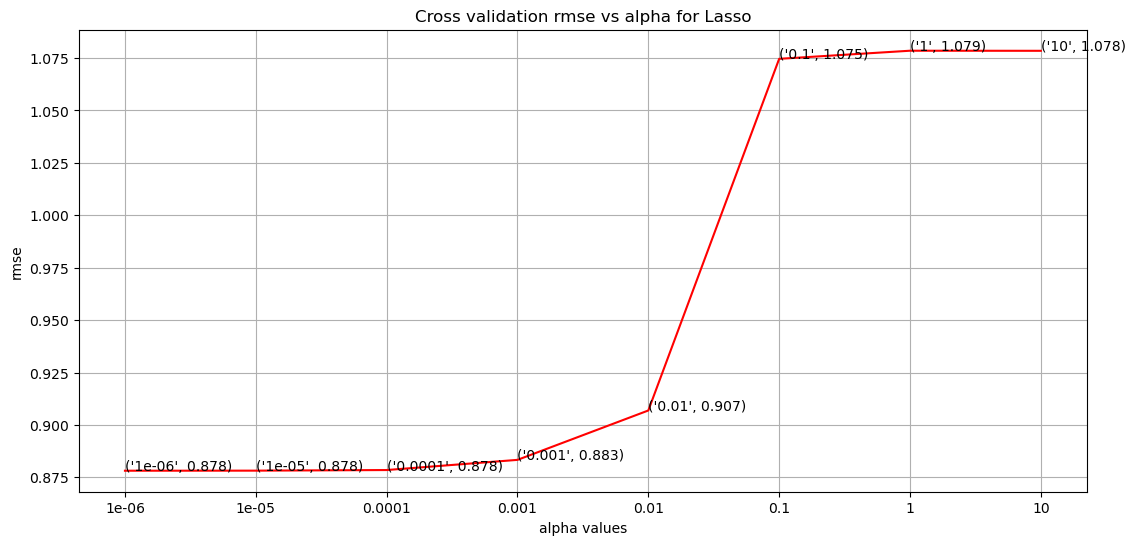

In [48]:
params = [str(i) for i in alpha]
fig,ax = plt.subplots(figsize=(13,6)) # figsize(width,height)
ax.plot(params,val_score,c='r') # line graph
for i, j in enumerate(np.round(val_score,3)): #(ennumerate gives no. to each iteraton and bind them)
    ax.annotate((params[i],j),(params[i],val_score[i])) #annotate gives notes to points on graph
plt.grid()
plt.title('Cross validation rmse vs alpha for Lasso')
plt.xlabel('alpha values')
plt.ylabel('rmse')
plt.show()

In [ ]:
# Ridge Regression
'''
alpha = [10 ** i for i in range(-4, 2)]
train_score = []
val_score = []
for i in tqdm(alpha):

    print("alpha = {} ".format(i))
    _model = Ridge(alpha=i)
    _model.fit(X_train, y_train)
    rmse_train = mean_squared_error(_model.predict(X_train).clip(0, 20), y_train, squared=False)
    rmse_val = mean_squared_error(_model.predict(X_val).clip(0, 20), y_val, squared=False)

    if val_score:
        if sorted(val_score)[0] > rmse_val:
            print("model saving.....")
            with open('D:\\best_ridge', 'wb') as loc:
                pickle.dump(_model, loc)
    else:
        print("model saving.....")
        with open('D:\\best_ridge', 'wb') as loc:
            pickle.dump(_model, loc)

    train_score.append(rmse_train)
    val_score.append(rmse_val)
    print("Training Loss is {} ".format(rmse_train))
    print("Validation Loss is {} ".format(rmse_val))
    print("-" * 50)

with open('D:\\ridge_log', 'wb') as loc:
    pickle.dump((train_score, val_score, alpha), loc)
'''

In [49]:
print("-"*50)
with open('D:\\ridge_log','rb') as loc:
    train_score,val_score,alpha=pickle.load(loc)
print('train_score for Ridge:',train_score)
print('val_score for Ridge:',val_score)
print('alpha for Ridge:',alpha)

--------------------------------------------------
train_score for Ridge: [0.76818484, 0.76818484, 0.76818496, 0.7681859, 0.7681946, 0.7682997]
val_score for Ridge: [0.8782075, 0.87820745, 0.8782065, 0.8782052, 0.8782079, 0.87821287]
alpha for Ridge: [0.0001, 0.001, 0.01, 0.1, 1, 10]


C:\Users\arsam\anaconda3\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


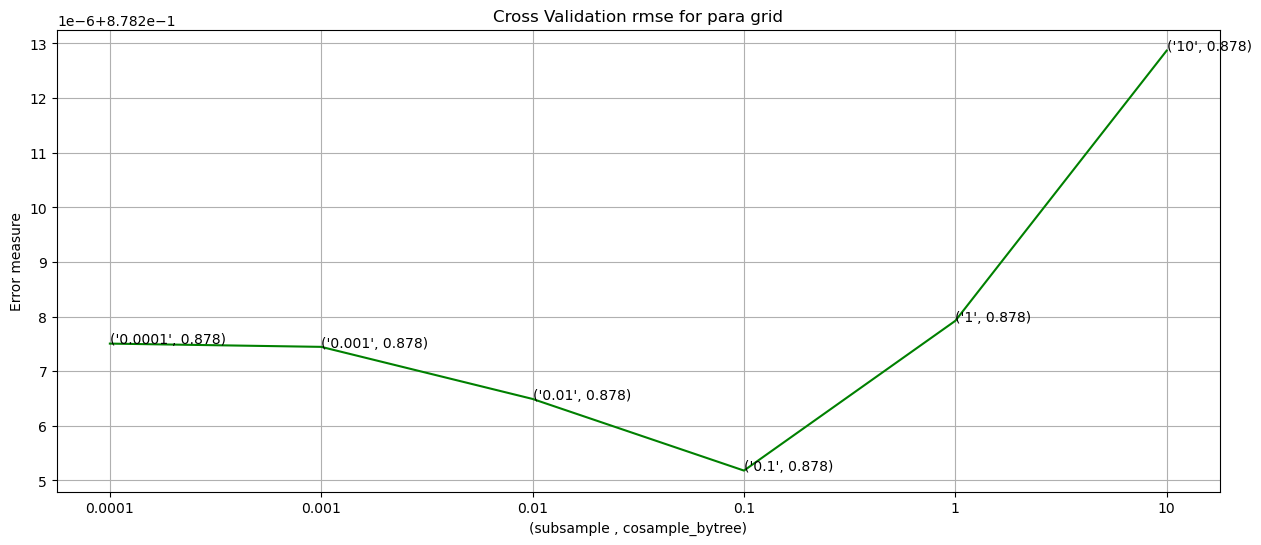

In [50]:

with open('D:\\best_ridge','rb') as loc:
    best_ridge = pickle.load(loc)
with open('D:\\ridge_log','rb') as loc:
    train_score,val_score,alpha = pickle.load(loc)
params = [str(i) for i in alpha]
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(params, val_score,c='g')
for i, txt in enumerate(np.round(val_score,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score[i]))
plt.grid()
plt.title("Cross Validation rmse for para grid")
plt.xlabel("(subsample , cosample_bytree)")
plt.ylabel("Error measure")
plt.show()


In [ ]:
'''
# DecisionTreeRegressor
alpha = [3, 5, 7, 9, 12]
train_score = []
val_score = []
for i in tqdm(alpha):

    print("alpha = {} ".format(i))
    _model = DecisionTreeRegressor(max_depth=i)
    _model.fit(X_train, y_train)
    rmse_train = mean_squared_error(_model.predict(X_train).clip(0, 20), y_train, squared=False)
    rmse_val = mean_squared_error(_model.predict(X_val).clip(0, 20), y_val, squared=False)

    if val_score:
        if sorted(val_score)[0] > rmse_val:
            print("model saving.....")
            with open('D:\\best_dt', 'wb') as loc:
                pickle.dump(_model, loc)
    else:
        print("model saving.....")
        with open('D:\\best_dt', 'wb') as loc:
            pickle.dump(_model, loc)

    train_score.append(rmse_train)
    val_score.append(rmse_val)
    print("Training Loss is {} ".format(rmse_train))
    print("Validation Loss is {} ".format(rmse_val))
    print("-" * 50)

with open('D:\\dt_log', 'wb') as loc:
    pickle.dump((train_score, val_score, alpha), loc)
'''

In [51]:
print("-"*50)
with open('D:\\dt_log','rb') as loc:
    train_score,val_score,alpha=pickle.load(loc)
print('train_score for DecisionTree:',train_score)
print('val_score for DecisionTree:',val_score)
print('alpha for DecisionTree:',alpha)

--------------------------------------------------
train_score for DecisionTree: [0.7951314103719336, 0.7721687960537307, 0.7567261079167922, 0.7388266584972821, 0.6855027963531569]
val_score for DecisionTree: [0.9053293721733748, 0.8865542228663715, 0.8883250536138586, 0.8974931028478114, 0.9457100734069066]
alpha for DecisionTree: [3, 5, 7, 9, 12]


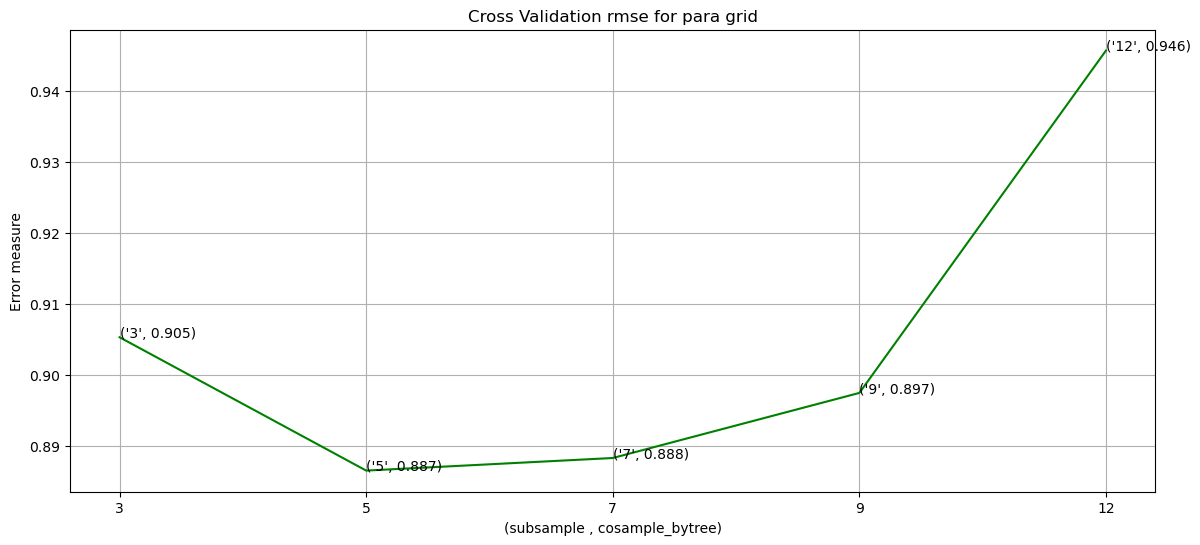

In [56]:
# line graph rmse vs alpha
# with open('D:\\best_dt','rb') as loc:
#    best_dt = pickle.load(loc)
with open('D:\\dt_log','rb') as loc:
    train_score,val_score,alpha = pickle.load(loc)
params = [str(i) for i in alpha]
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(params, val_score,c='g')
for i, txt in enumerate(np.round(val_score,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score[i]))
plt.grid()
plt.title("Cross Validation rmse for para grid")
plt.xlabel("(subsample , cosample_bytree)")
plt.ylabel("Error measure")
plt.show() 

In [54]:
# Graph for feature importance in DecisionTree
print(best_dt.feature_importances_)
feat_importances = pd.DataFrame(best_dt.feature_importances_, index=X.columns, columns=["Importance"])
print(feat_importances)
feat_importances.sort_values(by='Importance', ascending=True, inplace=True)
feat_importances.plot.barh(figsize=(14,6))
plt.show()

NameError: name 'best_dt' is not defined

In [ ]:
'''
# RandomForestRegressor
alpha = [3, 5, 7, 9]
train_score = []
val_score = []
for i in tqdm(alpha):

    print("alpha = {} ".format(i))
    _model = RandomForestRegressor(max_depth=i)
    _model.fit(X_train, y_train)
    rmse_train = mean_squared_error(_model.predict(X_train).clip(0, 20), y_train, squared=False)
    rmse_val = mean_squared_error(_model.predict(X_val).clip(0, 20), y_val, squared=False)

    if val_score:
        if sorted(val_score)[0] > rmse_val:
            print("model saving.....")
            with open('D:\\best_rf', 'wb') as loc:
                pickle.dump(_model, loc)
    else:
        print("model saving.....")
        with open('D:\\best_rf', 'wb') as loc:
            pickle.dump(_model, loc)

    train_score.append(rmse_train)
    val_score.append(rmse_val)
    print("Training Loss is {} ".format(rmse_train))
    print("Validation Loss is {} ".format(rmse_val))
    print("-" * 50)

with open('D:\\rf_log', 'wb') as loc:
    pickle.dump((train_score, val_score, alpha), loc)
'''

In [57]:
print("-"*50)
# with open('D:\\best_rf','rb') as loc:
#    best_rf = pickle.load(loc)
with open('D:\\rf_log','rb') as loc:
    train_score,val_score,alpha=pickle.load(loc)
print('train_score for Randomforest:',train_score)
print('val_score for RandomForest:',val_score)
print('alpha for Randomforest:',alpha)

--------------------------------------------------
train_score for Randomforest: [0.7902347560969996, 0.7669091858263252, 0.7493073829880835, 0.7266355478868254]
val_score for RandomForest: [0.8999394606788331, 0.8843916225026389, 0.87768421385041, 0.8711373383813517]
alpha for Randomforest: [3, 5, 7, 9]


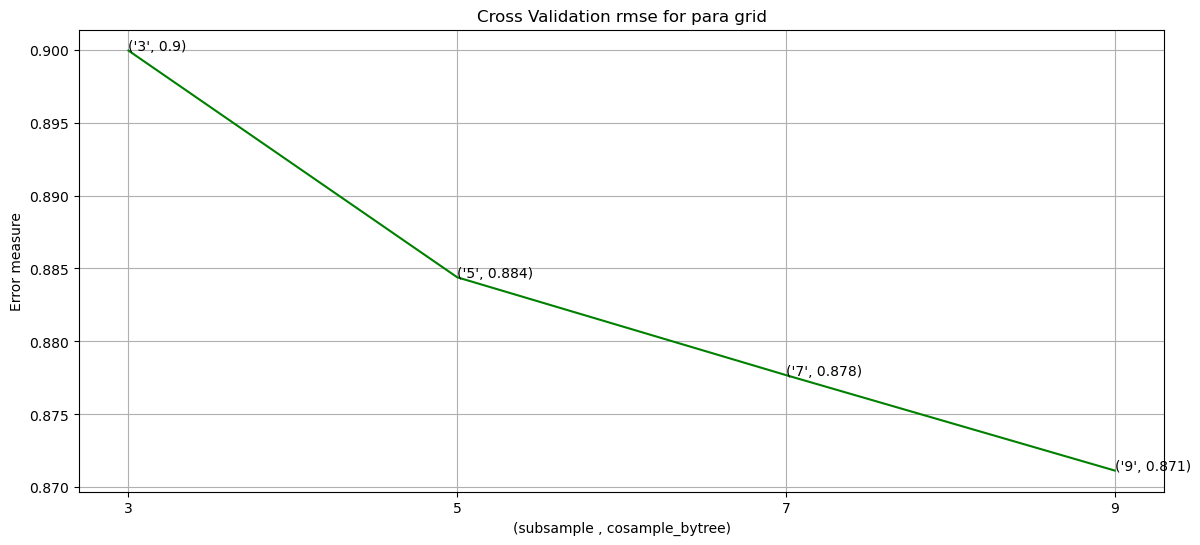

In [58]:
# line graph for rmse vs alpha
params = [str(i) for i in alpha]
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(params, val_score,c='g')
for i, txt in enumerate(np.round(val_score,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score[i]))
plt.grid()
plt.title("Cross Validation rmse for para grid")
plt.xlabel("(subsample , cosample_bytree)")
plt.ylabel("Error measure")
plt.show()

In [ ]:
# graph for feature importance:
feat_importances = pd.DataFrame(best_rf.feature_importances_, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=True, inplace=True)
feat_importances.plot.barh(figsize=(8,6))
plt.show()

In [ ]:
# XGBoost Regressor_1:
# Custom Grid search Part 1 with max_depth and min_child_weight:
'''
max_depth = [5, 9, 10, 14]
min_child_weight = [1, 6,10]

fit_params={"early_stopping_rounds":20,
            "eval_metric" : "rmse",
            "eval_set" : [[X_val, y_val]] }

train_score = []
val_score = []
params = []
for i in max_depth:
    for j in min_child_weight:
        print("Tuning parameter max_depth and min_child_weight")
        print("set max_depth = {} and min_child_weight = {}".format(i,j))
        _model = XGBRegressor(eta = 0.1, n_estimators=1000,max_depth=i ,min_child_weight=j, verbose=100)
        _model.fit(X_train, y_train, verbose=True, **fit_params)
        rmse_train = mean_squared_error(_model.predict(X_train).clip(0,20),y_train, squared=False)
        rmse_val = mean_squared_error(_model.predict(X_val).clip(0,20),y_val, squared=False)

        if val_score:
            if sorted(val_score)[0] > rmse_val:
                print("model saving.....")
                with open('D:\\best_xgb_1','wb') as loc:
                    pickle.dump(_model,loc)
        else:
            print("model saving.....")
            with open('D:\\best_xgb_1','wb') as loc:
                pickle.dump(_model,loc)

        train_score.append(rmse_train)
        val_score.append(rmse_val)
        params.append((i,j))

        print("Training Loss when max_depth={} and min_child_weight={} is {} ".format(i,j,rmse_train))
        print("Validation Loss when max_depth={} and min_child_weight={} is {} ".format(i,j,rmse_val))
        print("-"*50)

with open('D:\\xgb_log_1','wb') as loc:
    pickle.dump((train_score,val_score,params),loc)
'''

In [59]:
print("-"*50)
with open('D:\\best_xgb_1','rb') as loc:
    best_xgb_1 = pickle.load(loc)
with open('D:\\xgb_log_1','rb') as loc:
    train_score,val_score,params=pickle.load(loc)
print('train_score for xgb1:',train_score)
print('val_score for xgb1:',val_score)
print('params for xgb1:',params)

--------------------------------------------------
[09:36:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

train_score for xgb1: [0.7009856, 0.712158, 0.701862, 0.67327243, 0.685832, 0.69982904, 0.6699943, 0.6687526, 0.6801428, 0.6453254, 0.6456853, 0.6299429]
val_score for xgb1: [0.8516236, 0.8561162, 0.8524107, 0.85661453, 0.8579677, 0.8562211, 0.8607205, 0.8584937, 0.8595317, 0.8941534, 0.88954836, 0.8923189]
params for xgb1: [(5, 1), (5, 6), (5, 10), (9, 1), (9, 6), (9, 10), (10, 1), (10, 6), (10, 10), (14, 1), (14, 6), (14, 10)]


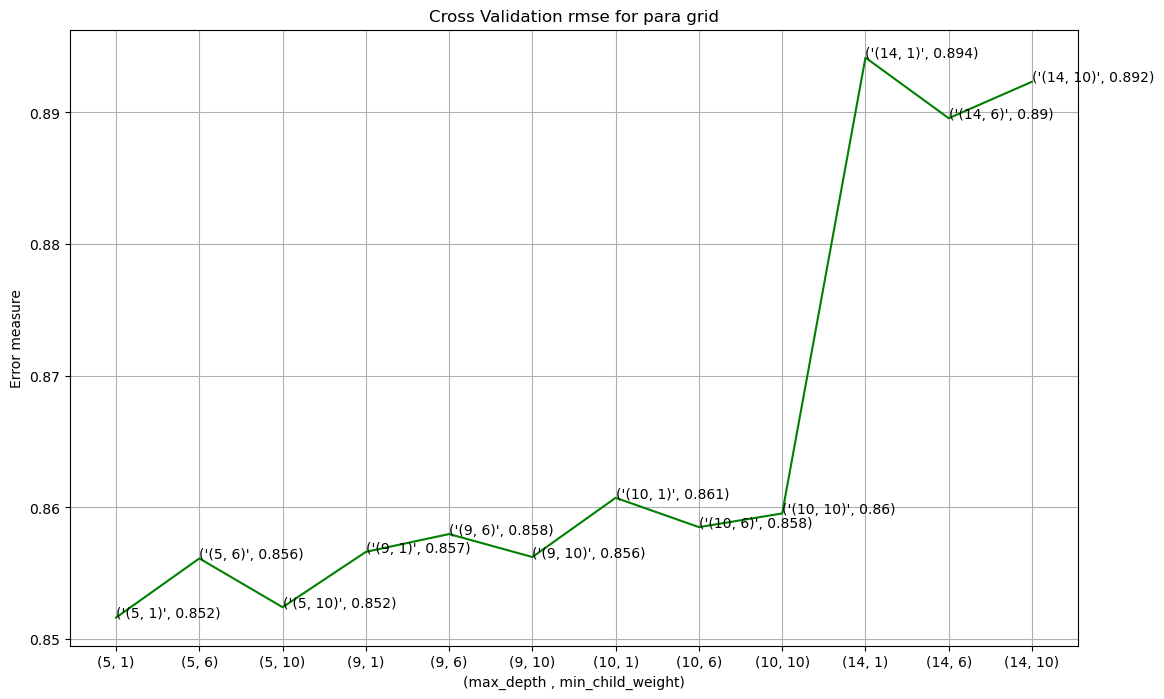

In [60]:
# line graph for rmse vs params
params = [str(i) for i in params]
fig, ax = plt.subplots(figsize=(13,8))
ax.plot(params, val_score,c='g')
for i, txt in enumerate(np.round(val_score,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score[i]))
plt.grid()
plt.title("Cross Validation rmse for para grid")
plt.xlabel("(max_depth , min_child_weight)")
plt.ylabel("Error measure")
plt.show()

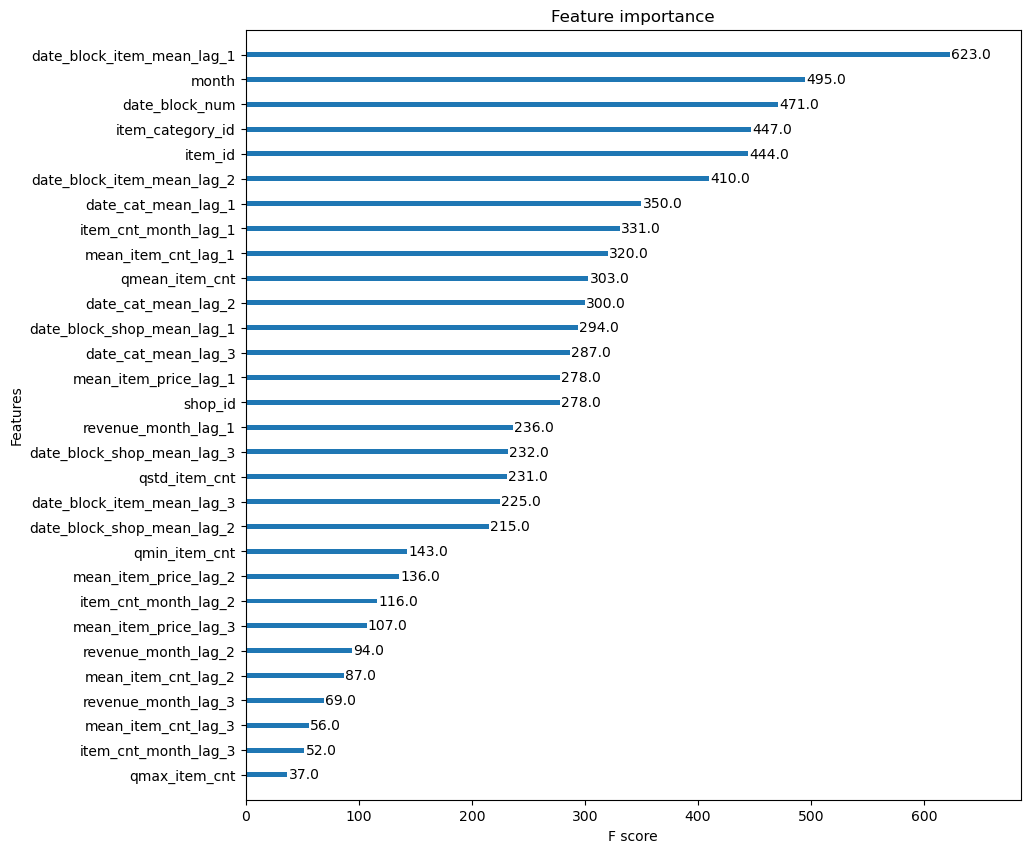

In [61]:
# Plot feature importance
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    plot_importance(booster=booster, ax=ax, grid=False)
    return plt.show()

plot_features(best_xgb_1, (10,10))
# We get the best score with max_depth = 10 and min_child_weight = 6.

In [ ]:
# XGBoost Regressor_2:
# Custom Grid search Part 2 with subsample and cosample_bytree:
'''
subsample = [1, 0.8, 0.6, 0.3]
cosample_bytree = [1, 0.8, 0.6, 0.3]
fit_params={"early_stopping_rounds":10,
            "eval_metric" : "rmse",
            "eval_set" : [[X_val, y_val]] }

best_param_1 = params[np.argmin(val_score)] # it gives index of min value

train_score_2 = []
val_score_2 = []
params_2 = []
for i in subsample:
    for j in cosample_bytree:
        print("Tuning parameter subsamle and cosample_bytree")
        print("set max_depth = {} and min_child_weight = {}".format(best_param_1[0],best_param_1[1]))
        print("set subsamle = {} and cosample_bytree = {}".format(i,j))
        _model = XGBRegressor(eta = 0.1, n_estimators=1000,
                              max_depth=best_param_1[0] ,
                              min_child_weight=best_param_1[1],
                              subsample=i,colsample_bytree=j)
        _model.fit(X_train, y_train, verbose=True, **fit_params)
        rmse_train = mean_squared_error(_model.predict(X_train).clip(0,20),y_train, squared=False)
        rmse_val = mean_squared_error(_model.predict(X_val).clip(0,20),y_val, squared=False)

        if val_score_2:
            if sorted(val_score_2)[0] > rmse_val:
                print("saving model.....")
                with open('D:\\best_xgb_2','wb') as loc:
                    pickle.dump(_model,loc)
        else:
            print("saving model.....")
            with open('D:\\best_xgb_2','wb') as loc:
                pickle.dump(_model,loc)

        train_score_2.append(rmse_train)
        val_score_2.append(rmse_val)
        params_2.append((i,j))

        print("Training Loss when subsample={} and cosample_bytree={} is {} ".format(i,j,rmse_train))
        print("Validation Loss when subsample={} and cosample_bytree={} is {} ".format(i,j,rmse_val))
        print("-"*50)
with open('D:\\xgb_log_2','wb') as loc:
    pickle.dump((train_score_2,val_score_2,params_2),loc)
'''

In [62]:
print("-"*50)
with open('D:\\best_xgb_2','rb') as loc:
    best_xgb_2 = pickle.load(loc)
with open('D:\\xgb_log_2','rb') as loc:
    train_score_2,val_score_2,params_2=pickle.load(loc)
print('train_score for xgb2:',train_score_2)
print('val_score for xgb2:',val_score_2)
print('params for xgb2:',params_2)

--------------------------------------------------
[09:39:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

train_score for xgb2: [0.7154735, 0.71134776, 0.7297207, 0.7149598, 0.717519, 0.7162684, 0.7183849, 0.7309786, 0.7192949, 0.7338202, 0.7344699, 0.73278826, 0.7291146, 0.74486893, 0.7192518, 0.7181146]
val_score for xgb2: [0.8545262, 0.85426176, 0.86044586, 0.8539684, 0.854822, 0.85407585, 0.85628223, 0.8586731, 0.8552272, 0.86025846, 0.8609172, 0.8585558, 0.85995746, 0.8622578, 0.8548132, 0.8548047]
params for xgb2: [(1, 1), (1, 0.8), (1, 0.6), (1, 0.3), (0.8, 1),

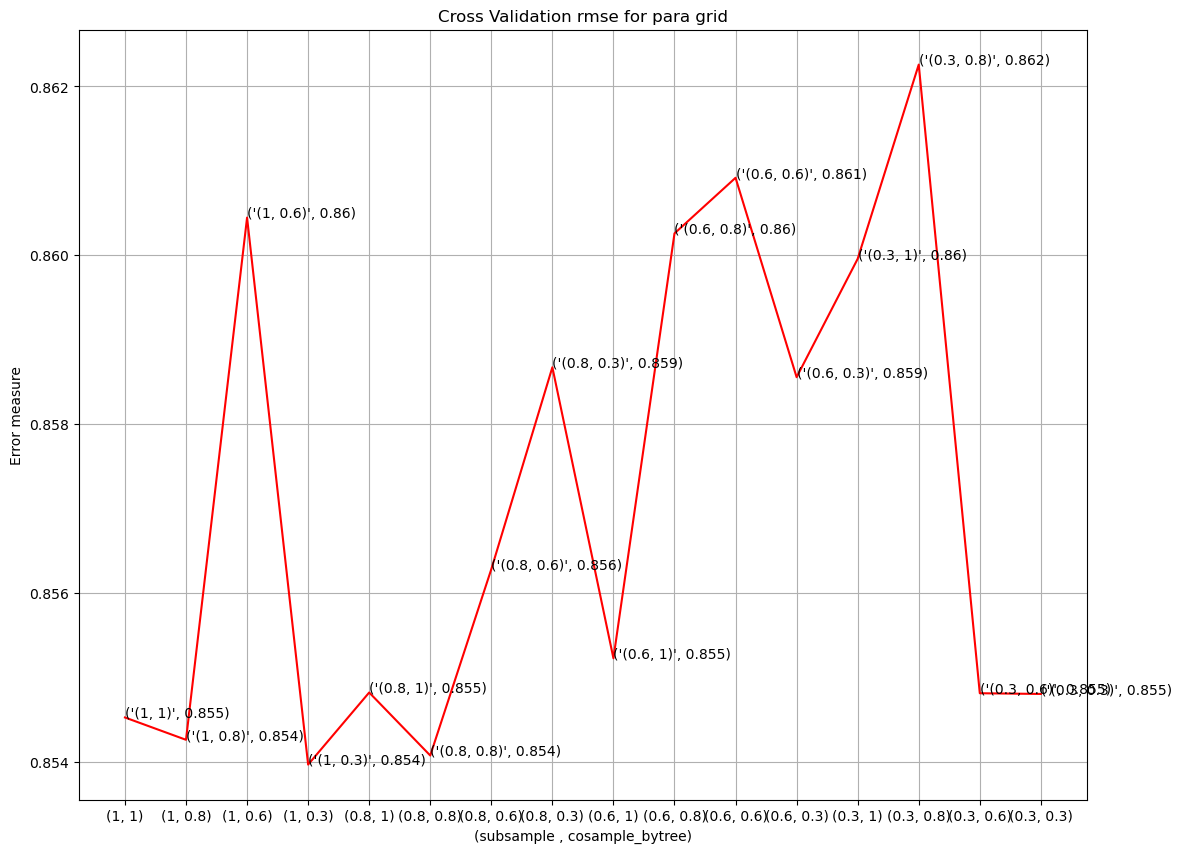

In [63]:
# line graph for rmse vs params
params = [str(i) for i in params_2]
fig, ax = plt.subplots(figsize=(13,10))
ax.plot(params, val_score_2,c='r')
for i, txt in enumerate(np.round(val_score_2,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score_2[i]))
plt.grid()
plt.title("Cross Validation rmse for para grid")
plt.xlabel("(subsample , cosample_bytree)")
plt.ylabel("Error measure")
plt.show()

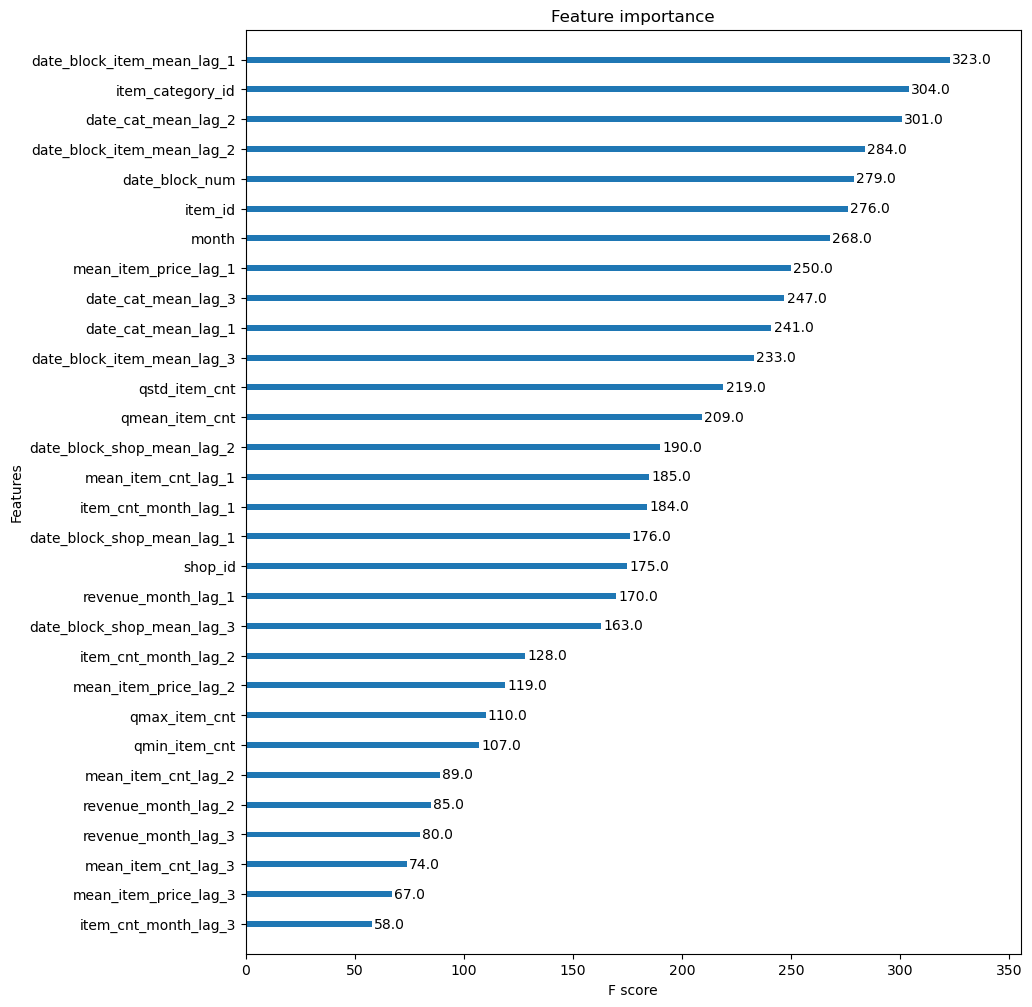

In [64]:
# feature importance:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    plot_importance(booster=booster, ax=ax, grid=False)
    return plt.show()

plot_features(best_xgb_2, (10,12))

In [ ]:
'''
# Training
xgb_final = XGBRegressor(
    max_depth=5,
    n_estimators=1000,
    min_child_weight=1,
    colsample_bytree=0.3,
    subsample=1,
    eta=0.1,
    seed=42)

xgb_final.fit(
    X_train,
    y_train,
    eval_metric="rmse",
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True,
    early_stopping_rounds = 20)

rmse_train_final = mean_squared_error(xgb_final.predict(X_train).clip(0,20),y_train, squared=False)
rmse_val_final = mean_squared_error(xgb_final.predict(X_val).clip(0,20),y_val, squared=False)



with open('D:\\xgb_final','wb') as loc:
    pickle.dump(xgb_final,loc)
with open('D:\\xgb_final_log_','wb') as loc:
    pickle.dump((rmse_train_final,rmse_val_final),loc)
'''

In [65]:
print("-"*50)
with open('D:\\xgb_final_log_','rb') as loc:
    rmse_train_final,rmse_val_final=pickle.load(loc)
print('rmse_train_xgbfinal:',rmse_train_final)
print('rmse_val_xgbfinal:',rmse_val_final)

--------------------------------------------------
rmse_train_xgbfinal: 0.71676195
rmse_val_xgbfinal: 0.85393155


In [68]:
with open('D:\\best_lasso','rb') as loc:
    best_lasso = pickle.load(loc)
with open('D:\\lasso_log','rb') as loc:
    lasso_log = pickle.load(loc)
with open('D:\\best_ridge','rb') as loc:
    best_ridge = pickle.load(loc)
with open('D:\\ridge_log','rb') as loc:
    ridge_log = pickle.load(loc)
#with open('D:\\best_dt','rb') as loc:
#    best_dt = pickle.load(loc)
with open('D:\\dt_log','rb') as loc:
    dt_log = pickle.load(loc)
#with open('D:\\best_rf','rb') as loc:
#    best_rf = pickle.load(loc)
with open('D:\\rf_log','rb') as loc:
    rf_log = pickle.load(loc)
with open('D:\\best_xgb_1','rb') as loc:
    best_xgb_1 = pickle.load(loc)
with open('D:\\xgb_log_1','rb') as loc:
    xgb_log_1 = pickle.load(loc)
with open('D:\\best_xgb_2','rb') as loc:
    best_xgb_2 = pickle.load(loc)
with open('D:\\xgb_log_2','rb') as loc:
    xgb_log_2 = pickle.load(loc)
with open('D:\\xgb_final_log_','rb') as loc:
    xgb_final_log=pickle.load(loc)

[09:48:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[09:48:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [69]:
x = PrettyTable()
x.field_names = ["Model", "train_rmse" , "val_rmse"]
x.add_row(["Lasso Regression", round(lasso_log[0][np.argmin(lasso_log[1])],5), round(min(lasso_log[1]),5)])
x.add_row(["Ridge Regression", round(ridge_log[0][np.argmin(ridge_log[1])],5), round(min(ridge_log[1]),5)])
x.add_row(["Decision tree Regressor", round(dt_log[0][np.argmin(dt_log[1])],5), round(min(dt_log[1]),5)])
x.add_row(["Random Forest Regressor", round(rf_log[0][np.argmin(rf_log[1])],5), round(min(rf_log[1]),5)])
x.add_row(["XGB Regressor 1", round(xgb_log_1[0][np.argmin(xgb_log_1[1])],5), round(min(xgb_log_1[1]),5)])
x.add_row(["XGB Regressor 2", round(xgb_log_2[0][np.argmin(xgb_log_2[1])],5), round(min(xgb_log_2[1]),5)])
x.add_row(['XGB REGRESSOR FINAL',round(xgb_final_log[0],5),round(xgb_final_log[1],5)])
print(x)

+-------------------------+------------+----------+
|          Model          | train_rmse | val_rmse |
+-------------------------+------------+----------+
|     Lasso Regression    |   0.7682   | 0.87815  |
|     Ridge Regression    |  0.76819   | 0.87821  |
| Decision tree Regressor |  0.77217   | 0.88655  |
| Random Forest Regressor |  0.72664   | 0.87114  |
|     XGB Regressor 1     |  0.70099   | 0.85162  |
|     XGB Regressor 2     |  0.71496   | 0.85397  |
|   XGB REGRESSOR FINAL   |  0.71676   | 0.85393  |
+-------------------------+------------+----------+


In [70]:
# predicting any value
def predict_sales(shop_id, item_id):
    with open('D:\\xgb_final', 'rb') as loc:
        xgb_final = pickle.load(loc)
    try:
        pred = xgb_final.predict(X_test[X_test.shop_id == shop_id][X_test.item_id == item_id]).clip(0, 20)
        return print('prediction : {}'.format(int(pred)))
    except:
        return print("Please enter valid shop_id/item_id")

In [71]:
predict_sales(5,5002)

[09:48:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

prediction : 0


C:\Users\arsam\AppData\Local\Temp\ipykernel_12520\982144161.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pred = xgb_final.predict(X_test[X_test.shop_id == shop_id][X_test.item_id == item_id]).clip(0, 20)
C:\Users\arsam\anaconda3\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\arsam\anaconda3\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\arsam\anaconda3\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\arsam\anaconda3\lib\site-package

In [72]:
def predict_score(shop_id, item_id):
    with open('D:\\xgb_final', 'rb') as loc:
        best_model = pickle.load(loc)
    try:
        pred = best_model.predict(X_val[X_val.shop_id == shop_id][X_val.item_id == item_id]).clip(0, 20)
        y = y_val[X_val.shop_id == shop_id][X_val.item_id == item_id]
        rmse = mean_squared_error(pred, y, squared=False)
        mse = mean_squared_error(pred, y, squared=True)
        print('RMSE score : {}'.format(mean_squared_error(pred, y, squared=False)))
        print('RMSE:',rmse)
        print('MSE:',mse)
    except:
        return print("Please enter valid shop_id/item_id")

In [73]:
predict_score(5,5002)

[09:52:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

RMSE score : 0.2590126693248749
RMSE: 0.2590126693248749
MSE: 0.06708756287079698


C:\Users\arsam\AppData\Local\Temp\ipykernel_12520\2617780058.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pred = best_model.predict(X_val[X_val.shop_id == shop_id][X_val.item_id == item_id]).clip(0, 20)
C:\Users\arsam\anaconda3\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\arsam\anaconda3\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\arsam\anaconda3\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\arsam\anaconda3\lib\site-packages

In [74]:
with open('D:\\preprocessed_set','rb') as loc:
    X, y = pickle.load(loc)
print(y.unique())
print(y.value_counts())

[ 0.  1.  3.  2.  9.  4. 20. 12.  5. 11.  6. 13. 15.  7. 10. 18.  8. 17.
 16. 19. 14.]
item_cnt_month
0.000     6901843
1.000      357262
2.000      109327
3.000       45491
4.000       24207
5.000       14895
6.000        9746
7.000        6530
20.000       6401
8.000        4944
9.000        3503
10.000       2781
11.000       2051
12.000       1686
13.000       1463
14.000       1136
15.000        988
16.000        814
17.000        751
18.000        626
19.000        555
Name: count, dtype: int64
